# End-to-end Edge Computer Vision (CV) Machine Learning (ML) Orchistration
---
**Table of Contents:**

1. [Introduction](#Introduction)
2. [Prerequisites](#Prerequisites)
3. [Setup](#Setup)
4. [Dataset](#Dataset)
5. [Start a GroundTruth labeling workflow for CV](#Start-A-GroundTruth-Labeling-Workflow)
6. [Pipeline Automation with S3 Lambda](#Pipeline-Automation-with-S3-Lambda)
7. [Build a Training Pipeline](#Build-a-Training-Pipeline)
    1. [Preprocessing Script](#Preprocessing-Script)
    
       1. [Bring Your Own Container (BYOC)](#Bring-Your-Own-Container-(BYOC))
       
       2. [Generate TFRecord for pipe mode](#Generate-TFRecord-for-pipe-mode)
       
       3. [Use Fast File Mode](#Use-Fast-File-Mode)
    
    2. [Training Script](#Training-Script)
    
       1. [SageMaker Debugger](#SageMaker-debugger)
       
    3. [Evaluation Script](#Evaluation-Script)
    
    4. [Pipeline Code](#Pipeline-Code)
    
    5. [Trigger the Pipeline](#Trigger-the-Pipeline)
    
8. [Manual approval for deployment](#Manual-approval-for-deployment)

9. [Edge Deployment W/ AWS Panorama](#Edge-Deployment-W/-AWS-Panorama)
    
    1. [Setup device](#Setup-device)
    
    2. [Deploy applications and models](#Deploy-applications-and-models)
    
    3. [Setup Test Utility](#Setup-Test-Utility)
    
    4. [Run Panorama Application](#Run-Panorama-Application
)
    
10. [Cleanup](#Clean-Up)

## Introduction

In this workshop, we will walk you through a step by step process to prepare, build and train computer vision models with Amazon SageMaker and deploy them to AWS panorama for edge inference. The workshop image classification of different species of birds, but the concept can be applied to a wide range of industrial applications. We will complete the CV MLOps lifecycle covering: data labeling, continuous integrated (CI/CD) training pipeline, model updates to the edge w/ approval, and, fianlly, edge inferencing and data capture back to the cloud.

## Architecture
---
![MLOps Pattern](statics/end2end.png)

The architecture we will build during this workshop is illustrated on the right. Several key components can be highlighted:

1. **Data labeling w/ SageMaker GroundTruth**: We are using the CUB_MINI.tar data which is a subset of [Caltech Birds (CUB 200 2011)](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) dataset. The code below will spin up a GoundTruth labeling job for private/public workforce to label.  The output is a fully labeled manifest file that can be ingested by the atutomated training pipeline.

2. **Automated training Pipeline** Once the dataset is fully labelled, we have prepared a SageMaker pipeline that will go through steps: preprocessing, model training, model evaluation, and storing the model to model registry.  At the same time, the example code will provide advance topics like streaming data with pipe mode and fast file mode, monitor training with SageMaker debugger, and distributed training to increase training effeciency and reduce training time.

3. **Model Deployment & Edge Inferencing w/ AWS Panorama** With manual approval of the model in Model registry, we can kick off the edge deploymnet with a deployment lambda.  That can be accomplish using the AWS Panorama API.  We will also illustration the edge application development and testing using the AWSW Panorama Test Utility (Emulator)

## Prerequisites

To run this notebook, you can simply execute each cell in order. To understand what's happening, you'll need:

- Access to the SageMaker default S3 bucket or use your own
- The S3 bucket that you use for this demo must have a CORS policy attached. To learn more about this requirement, and how to attach a CORS policy to an S3 bucket, see [CORS Permission Requirement](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-cors-update.html)
- <span style="color:red">The notebook use public workforce (Mechanical Turk) for the groundTruth labeling job. That will incur some cost at **$0.012 per image**.  If want to use a prviate workforce, then you must have a private workforce already created and update the code with your private workforce ARN. Please follow this [AWS documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-workforce-create-private-console.html) on how to create a private workforce</span>
- Access to Elastic Container Registry (ECR)
- Familiarity with Training on Amazon SageMaker
- Familiarity with SageMaker Processing Job
- Familiarity with SageMaker Pipeline
- Familiarity with Python
- Familiarity with AWS S3
- Basic familiarity with AWS Command Line Interface (CLI) -- ideally, you should have it set up with credentials to access the AWS account you're running this notebook from.
- SageMaker Studio is preferred for the full UI integration

## Setup

---
import the libraries and intialize the parameters for this workshop

In [ ]:
import sagemaker
import boto3
import os
import time
import datetime
import json
import numpy as np
import pprint as pp

from collections import namedtuple
from collections import defaultdict
from collections import Counter



import matplotlib.pyplot as plt

sagemaker_session = sagemaker.Session()

default_bucket = sagemaker_session.default_bucket() # or use your own custom bucket name
region = sagemaker_session.boto_region_name
account = sagemaker_session.account_id()
role = sagemaker.get_execution_role()

sess = sagemaker.Session()

base_job_prefix = 'BirdEnd2End'

## Dataset
The dataset we are using is from [Caltech Birds (CUB 200 2011)](http://www.vision.caltech.edu/visipedia/CUB-200-2011.html) dataset contains 11,788 images across 200 bird species (the original technical report can be found here). Each species comes with around 60 images, with a typical size of about 350 pixels by 500 pixels. Bounding boxes are provided, as are annotations of bird parts. A recommended train/test split is given, but image size data is not.

![Bird Dataset](statics/birds.png)

If you kept the data set from previous lab, just copy the files here.  Otherwise, run the cell below to download the full dataset or download manually [here](https://course.fast.ai/datasets). Note that the file size is around 1.2 GB, and can take a while to download. If you plan to complete the entire workshop, please keep the file to avoid re-download and re-process the data.

In [ ]:
!wget 'https://s3.amazonaws.com/fast-ai-imageclas/CUB_200_2011.tgz'
!tar xopf CUB_200_2011.tgz
!rm CUB_200_2011.tgz

Generating a test video for our Panorama Test Utility.  We will use this video to test our Panorama application. To do this, we will need opencv. Run the cell below to install the appropriate packages if your kernel does already have them.

The video `bird.mp4` will be created in `2_deployment` folder.  You can review the output there.

In [ ]:
!pip install opencv-python
!apt-get update
!apt-get install ffmpeg libsm6 libxext6  -y

In [ ]:
import cv2
import glob
import random

img_array = []
image_dir = 'CUB_200_2011/images'

subset_data = ["013.Bobolink", "017.Cardinal", 
               "035.Purple_Finch", "036.Northern_Flicker",
              "047.American_Goldfinch","068.Ruby_throated_Hummingbird",
               "073.Blue_Jay","087.Mallard"]

# create an array of available image files
for sub_dir in os.listdir(image_dir):
    if sub_dir in subset_data:

        for filename in os.listdir(f'{image_dir}/{sub_dir}'):
            img_array.append(f'{image_dir}/{sub_dir}/{filename}')
            
# all the images should be the same size, so grab teh image size from first image
img = cv2.imread(img_array[0])
height, width, layers = img.shape
size = (width,height)

output_path = '../2_deployment/bird.mp4'
out = cv2.VideoWriter(output_path,cv2.VideoWriter_fourcc(*'MP4V'), 1, size)

#random sample images and append as frames into the video
for i in range(200):
    rand_index = random.randint(0,len(img_array)-1)
    img = cv2.imread(img_array[rand_index])
    out.write(img)
out.release()

print(f'video generated at {output_path}')

## Start A GroundTruth Labeling Workflow

---
We will create a GroundTruth labeling job. This involves several steps: collecting the images we want labeled, specifying the possible label categories, creating instructions, and writing a labeling job specification. 

---
**Create and upload an input manifest file.** Each line in an input manifest file is an entry containing an object, or a reference to an object, to label. An entry can also contain labels from previous jobs and for some task types, additional information. [AWS Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-input-data-input-manifest.html)

If you do not want to go through the manual labeling process, the code below also generate a synthetic labelled output manifest file that is ready for training.  In that case, ** after you run the code below just **[skip to the next section](LambdaTrigger)**

In [ ]:
# Copy the images to our local bucket.

label_map = dict()
for i in range(len(subset_data)):
    label = subset_data[i].split('.')[-1]
    label_map[label] = i
        
s3 = boto3.client('s3')

input_manifest_name = 'input.manifest'
output_manifest_name = 'output.manifest'

# remove if file already exist
if os.path.exists(input_manifest_name):
    os.remove(input_manifest_name)
    
if os.path.exists(output_manifest_name):
    os.remove(output_manifest_name)

f = open(input_manifest_name, 'a')
g = open(output_manifest_name, 'a')

json_body = {'labels':[]}

print('Processing......\n')

for raw_label in os.listdir(image_dir):
    
    if raw_label in subset_data:
    
        label_name = raw_label.split('.')[-1]

        print(label_name, label_map[label_name])
        json_body['labels'].append({"label": label_name})

        for filename in os.listdir(f'{image_dir}/{raw_label}'):
            if '.jpg' in filename:
                key = f"{base_job_prefix}/unlabeled/images/{filename}"
                s3.upload_file(f'{image_dir}/{raw_label}/{filename}', default_bucket, key)

                img_path = f"s3://{default_bucket}/{key}"
                f.write('{"source-ref": "' + img_path + '"}\n')

                #build output manifest, if you don't want to go through the label        
                output_manifest = dict()

                output_manifest['source-ref'] = img_path
                output_manifest['label'] = label_map[label_name]
                label_metadata = dict()
                label_metadata['class-name'] = label_name
                # these are just placeholders to mimic an actual manifest file
                label_metadata['job-name'] = "labeling-job/bird-image-classification-1634678978"
                label_metadata['type'] = "groundtruth/image-classification"
                label_metadata['human-annotated'] = "yes"
                label_metadata['creation-date'] = str(datetime.datetime.now().isoformat(timespec='microseconds'))

                output_manifest['label-metadata'] = label_metadata

                g.write(f"{json.dumps(output_manifest)}\n")
        
        
f.close()
g.close()
        
        
input_manifest_key = f"{base_job_prefix}/unlabeled/manifest/{input_manifest_name}"
s3.upload_file(input_manifest_name, default_bucket, input_manifest_key)
        
s3_input_manifest = f"s3://{default_bucket}/{input_manifest_key}"

print("\nInput manifest file location:")
print(s3_input_manifest)

output_manifest_key = f"{base_job_prefix}/pipeline/manifest/{output_manifest_name}"
s3.upload_file(output_manifest_name, default_bucket, output_manifest_key)
        
s3_output_manifest = f"s3://{default_bucket}/{output_manifest_key}"

print("\nSynthetic output manifest file location: ")
print(s3_output_manifest)

remove data to save disc space

In [ ]:
!rm -rf ./CUB_200_2011
!rm -f attributes.txt

---
**Specify the categories with a `label.json` file**  To run an image classification labeling job, you need to decide on a set of classes the annotators can choose from. 
In our case, this list is `["Bobolink", "Cardinal", "Purple Finch"]`. In your own job you can choose any list of up to 10 classes. We recommend the classes to be as unambiguous and concrete as possible. The categories should be mutually exclusive, with only one correct label per image. In addition, be careful to make the task as *objective* as possible, unless of course your intention is to obtain subjective labels.

In [ ]:
pp.pprint(json_body)

class_file_name = "class_labels.json"
with open(class_file_name, "w") as f:
    json.dump(json_body, f)

classes_key = f"{base_job_prefix}/unlabeled/classes/{class_file_name}"
s3.upload_file(class_file_name, default_bucket, classes_key)

s3_classes = f"s3://{default_bucket}/{classes_key}"

s3_classes

**Create the instruction template** Part or all of your images will be annotated by human annotators. It is **essential** to provide good instructions that help the annotators give you the annotations you want. he labeling instruction template

In [ ]:
def make_template(test_template=False, save_fname="instructions.template"):
    template = r"""<script src="https://assets.crowd.aws/crowd-html-elements.js"></script>
        <crowd-form>
          <crowd-image-classifier
            name="crowd-image-classifier"
            src="{{ task.input.taskObject | grant_read_access }}"
            header="please classify"
            categories="{{ task.input.labels | to_json | escape }}"
          >
            <full-instructions header="Image classification instructions">
              <ol><li><strong>Read</strong> the task carefully and inspect the image.</li>
              <li><strong>Read</strong> the options and review the examples provided to understand more about the labels.</li>
              <li><strong>Choose</strong> the appropriate label that best suits the image.</li></ol>
            </full-instructions>
            <short-instructions>
              <p>Dear Annotator, please tell me whether what you can see in the image. Thank you!</p>
            </short-instructions>
          </crowd-image-classifier>
        </crowd-form>"""

    with open(save_fname, "w") as f:
        f.write(template)
    if test_template is False:
        print(template)

template_name = "instructions.template"
# make_template(test_template=True, save_fname="instructions.html")

make_template(test_template=False, save_fname=template_name)
templates_key = f"{base_job_prefix}/unlabeled/templates/{template_name}"
s3.upload_file(template_name, default_bucket, templates_key)

s3_templates = f"s3://{default_bucket}/{templates_key}"
print(f"S3 url: {s3_templates}")

---
Assign key labeling job resources (4 components)

**Assign pre-built resources in the labeling job** There are the ARNs for the four key components of the labeling job: 1) the workteam, 2) the annotation consolidation Lambda function, 3) the pre-labeling task Lambda function, and 4) the machine learning algorithm to perform auto-annotation.

<span style="color:red">**Note: put your own private workteam arn here or uncomment the code and use mechanical turk.**</span>

In [ ]:
# Specify ARNs for resources needed to run an image classification job.
ac_arn_map = {
    "us-west-2": "081040173940",
    "us-east-1": "432418664414",
    "us-east-2": "266458841044",
    "eu-west-1": "568282634449",
    "ap-northeast-1": "477331159723",
}

prehuman_arn = "arn:aws:lambda:{}:{}:function:PRE-ImageMultiClass".format(
    region, ac_arn_map[region]
)
acs_arn = "arn:aws:lambda:{}:{}:function:ACS-ImageMultiClass".format(region, ac_arn_map[region])

labeling_algorithm_specification_arn = "arn:aws:sagemaker:{}:027400017018:labeling-job-algorithm-specification/image-classification".format(
    region
)

#Update this code block if you want to use your own private workforce.
PRIVATE_WORKFORCE = False

public_workteam_arn = "arn:aws:sagemaker:{}:394669845002:workteam/public-crowd/default".format(region)

# private_workteam_arn = "<REPLACE WITH YOUR OWN PRIVATE TEAM ARN>"

---
Submit the Ground Truth job request

In [ ]:
job_name = "bird-image-classification-" + str(int(time.time())).split('.')[0]

# define human task configuration
human_task_config = {
    "AnnotationConsolidationConfig": {
        "AnnotationConsolidationLambdaArn": acs_arn,
    },
    "PreHumanTaskLambdaArn": prehuman_arn,
    "MaxConcurrentTaskCount": 200,  # 200 images will be sent at a time to the workteam.
    "NumberOfHumanWorkersPerDataObject": 3,  # 3 separate workers will be required to label each image.
    "TaskAvailabilityLifetimeInSeconds": 21600,  # Your worteam has 6 hours to complete all pending tasks.
    "TaskDescription": 'Carefully inspect the image and classify it by selecting one label from the categories provided.',
    "TaskKeywords": ["image", "classification", "birds"],
    "TaskTimeLimitInSeconds": 300,  # Each image must be labeled within 5 minutes.
    "TaskTitle": 'What bird is this',
    "UiConfig": {
        "UiTemplateS3Uri": s3_templates,
    },
}

# Using public or private workforce.  Public workforce require price info
if not PRIVATE_WORKFORCE:
    human_task_config["PublicWorkforceTaskPrice"] = {
        "AmountInUsd": {
            "Dollars": 0,
            "Cents": 1,
            "TenthFractionsOfACent": 2,
        }
    }
    human_task_config["WorkteamArn"] = public_workteam_arn
else:
    human_task_config["WorkteamArn"] = private_workteam_arn
    
ground_truth_request = {
    "InputConfig": {
        "DataSource": {
            "S3DataSource": {
                "ManifestS3Uri": s3_input_manifest
            }
        },
        "DataAttributes": {
            "ContentClassifiers": ["FreeOfPersonallyIdentifiableInformation", "FreeOfAdultContent"]
        },
    },
    "OutputConfig": {
        "S3OutputPath": f's3://{default_bucket}/{base_job_prefix}/labeled',
    },
    "HumanTaskConfig": human_task_config,
    "LabelingJobName": job_name,
    "RoleArn": role,
    "LabelAttributeName": "category",
    "LabelCategoryConfigS3Uri": s3_classes,
}

sagemaker_client = boto3.client("sagemaker")
sagemaker_client.create_labeling_job(**ground_truth_request)

---
**Monitoring the labelling job status**

In [ ]:
# job_name = 'bird-image-classification-1647438119'
# sagemaker_client = boto3.client("sagemaker")
sagemaker_client.describe_labeling_job(LabelingJobName=job_name)

---
**Analyze Ground Truth labeling job results**

After the job finishes running (**make sure `sagemaker_client.describe_labeling_job` shows the job is complete!**), it is time to analyze the results. In this section, we will gain additional insights into the results, all contained in the `output manifest`. You can find the location of the output manifest under `AWS Console > SageMaker > Labeling Jobs > [name of your job]`. We will obtain it programmatically in the cell below.

In [ ]:
# Load the output manifest's annotations.
output_manifest = f"s3://{default_bucket}/{base_job_prefix}/labeled/{job_name}/manifests/output/output.manifest"

!aws s3 cp {output_manifest} 'output.manifest'

with open("output.manifest", "r") as f:
    output = [json.loads(line.strip()) for line in f.readlines()]

# Create data arrays.
img_uris = [None] * len(output)
confidences = np.zeros(len(output))
groundtruth_labels = [None] * len(output)
human = np.zeros(len(output))

# Find the job name the manifest corresponds to.
keys = list(output[0].keys())
metakey = keys[np.where([("-metadata" in k) for k in keys])[0][0]]
jobname = metakey[:-9]

# Extract the data.
for datum_id, datum in enumerate(output):
    img_uris[datum_id] = datum["source-ref"]
    groundtruth_labels[datum_id] = str(datum[metakey]["class-name"])
    confidences[datum_id] = datum[metakey]["confidence"]
    human[datum_id] = int(datum[metakey]["human-annotated"] == "yes")
groundtruth_labels = np.array(groundtruth_labels)

In [ ]:
# Compute the number of annotations in each class.
n_classes = len(set(groundtruth_labels))
sorted_clnames, class_sizes = zip(*Counter(groundtruth_labels).most_common(n_classes))

# Find ids of human-annotated images.
human_sizes = [human[groundtruth_labels == clname].sum() for clname in sorted_clnames]
class_sizes = np.array(class_sizes)
human_sizes = np.array(human_sizes)

plt.figure(figsize=(9, 3), facecolor="white", dpi=100)
plt.title("Annotation histogram")
plt.bar(range(n_classes), human_sizes, color="gray", hatch="/", edgecolor="k", label="human")
plt.bar(
    range(n_classes),
    class_sizes - human_sizes,
    bottom=human_sizes,
    color="gray",
    edgecolor="k",
    label="machine",
)
plt.xticks(range(n_classes), sorted_clnames, rotation=90)
plt.ylabel("Annotation Count")
plt.legend()
plt.show()

## Pipeline Automation with S3 Lambda

---
There are several popular ways to trigger a SageMaker pipeline

1. Use a lambda triggered by S3 event, where we monitor a S3 bucket for a new lablled manifest file. We demonstrate an example of that in [week 4 MLOps training](https://master.d2g2roqxvwdnfj.amplifyapp.com/orchestration.html)

2. Use Source control. CodeCommit and especially [third-party source controls](https://aws.amazon.com/blogs/machine-learning/create-amazon-sagemaker-projects-using-third-party-source-control-and-jenkins/). 

3. Use EventBridge. Essentially any events support by EventBridge event bus (AWS and third party) [AWS Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/pipeline-eventbridge.html)

4. Last but not least, you can trigger an existing pipeline from the SageMaker Studio UI.

In [ ]:
# image location
s3_input_data = f"s3://{default_bucket}/{base_job_prefix}/unlabeled/images"
# labelled manifest location
s3_input_manifest = f"s3://{default_bucket}/{base_job_prefix}/pipeline/manifest"

## Build a Training Pipeline
---

The pipelines configured includes python package under SageMaker Pipelines together with the defined code for preprocessing, training, and model evaluation to automate the model training. It is easy to use such that you can simple drop in whatever input data for image classification you want and have it train a model automatically.

### Preprocessing Script

---
Here is teh preprocessing script. we are using script processor from sageMaker processing to split the data into train, valid, and test channels, and then build the TFRecord file for pipe mode training.

In [ ]:
!pygmentize 'pipeline/preprocess.py'

#### Bring Your Own Container (BYOC)
---

Since we are using our own container for both pre and post processing, we need to build our own container and registered to ECR. The docker file is supplied in to docker folder.

The easist way to build a docker image and upload to ECR is to use SageMaker Docker module.  **Skip** if you already have it.

In [ ]:
!pip install sagemaker-studio-image-build

Build the docker image.  You will need necessary permission like codebuild, assumerole, etc to run this command, please reference this [blog](https://aws.amazon.com/blogs/machine-learning/using-the-amazon-sagemaker-studio-image-build-cli-to-build-container-images-from-your-studio-notebooks/) for more details.

In [ ]:
container_name = "sagemaker-tf-container"
!cd docker && sm-docker build . --file Dockerfile --repository $container_name:2.0
    
ecr_image = "{}.dkr.ecr.{}.amazonaws.com/{}:2.0".format(account, region, container_name)

#### Generate TFRecord for pipe mode

---
TFRecord is TensorFlow's custom data format that uses Protocol Buffers to serialize/deserialize the data and store them in bytes. It takes less space to hold and transfer an ample amount of data, and it is also cross-platform supported with libraries across all program languages.

With TFRecord data format, the user can also uncover the Pipe Mode training on SageMkaer.  It is an input mechanism that streams the data to the training conatiners, which allows data to be downloaded from S3 to the container while training is running. For larger datasets, this dramatically improves the time to start training, as the data does not need to be first downloaded to the container. To learn more, please reference [AWS Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo.html#your-algorithms-training-algo-running-container-trainingdata)

#### Use Fast File Mode

---
Newly release in Oct, 2021.  Amazon SageMaker now supports Fast File Mode for accessing data in training jobs. This enables high performance data access by streaming directly from Amazon S3 with no code changes from the existing File Mode. [AWS Documentation](https://aws.amazon.com/about-aws/whats-new/2021/10/amazon-sagemaker-fast-file-mode/)

### Training Script

---
We are training a Tensorflow(TF) 2.x model for image classification.  This is a transfer learning example using Keras MobileNetV2 model.  We will be bring in our own script to training on SageMaker standard TF containers.  Couple things to highlight about this custom script:

1. the training uses pipe mode to stream data directly from Amazon S3 allowing faster start to model training.

2. We provide an distributed training example using xxxxx to boost training effeciency for large model and datasets, and cut down on training time.

3. Sagemaker debugger profiler and rules alerts are attached to the training to monitor the training for abnormal behavior

In [ ]:
!pygmentize 'pipeline/code/train_debugger.py'

#### SageMaker debugger

---
[Amazon SageMaker Debugger](https://docs.aws.amazon.com/sagemaker/latest/dg/train-debugger.html) debugs, monitors and profiles training jobs in real time thereby helping with detecting non-converging conditions, optimizing resource utilization by eliminating bottlenecks, improving training time and reducing costs of your machine learning models.

<a id ='debugger'> </a>

1. **Profile config** - configure how to collect system metrics and framework metrics from your training job and save into your secured S3 bucket URI or local machine.

    1. [Monitoring hardware system resource utilization](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-configure-system-monitoring.html)
  
    2. [Framework profiling](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-configure-framework-profiling.html)
  
2. **Debugger hook config** - configure how to collect output tensors from your training job and save into your secured S3 bucket URI or local machine.  For more info, refer [here](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-configure-hook.html).

3. **Rules** - configure this parameter to enable Debugger built-in rules that you want to run in parallel. The rules automatically analyze your training job and find training issues. The ProfilerReport rule saves the Debugger profiling reports in your secured S3 bucket URI.  For more info, refer [here](https://docs.aws.amazon.com/sagemaker/latest/dg/use-debugger-built-in-rules.html).

![Debugger](statics/debugger_access.png)

### Evaluation Script

---
Evaluation is also using script processor from SageMaker processing with the same container as preprocessing.  It loads the test dataset and the model to calculate model metrics like Accuracy, Precision, Recall, F1, and confussion matrix.  Only model with accuracy >= 80% will be registered in Model Registry.

If model passes the evaluation criteria, all the metrics will be captured in Model Registry for manual approvel to deploy. The models are also automatic are automatically versioned with full lineage history, and you can compare different version of the models side-by-side as shown in image below:

![Model Registry](statics/model_registry.png)

In [ ]:
!pygmentize 'pipeline/evaluation.py'

### Pipeline Code

---
SageMaker Pipelines is generating a directed acyclic graph (DAG) in the form of a JSON pipeline definition.  The provided python code using SageMaker Python SDK is an easy way to generate the JSON pipleine definition for you.  In general, the code goes through and define each step of the pipeline, feed output from one step to the input for another.  In the end, all the parameters and steps are chained together to formulate the pipeline.

Couple new features to highlight:

1. **Caching Pipeline Steps** SageMaker will attempt to find a previous execution of a step that was called with the same arguments in order to save time on repeated pipeline runs. [AWS Documenation](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-caching.html)

2. **Retry Policy** is a recent released feature that help you automatically retry pipeline steps after an error occurs. [AWS Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-retry-policy.html)

3. **Tuning Step** is a new pipeline step that allows you to run tuning jobs in your pipeline across ranges of hyperparameters and pickout the best model combination to deploy. We provide an example in this workshop. [AWS Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html)

In [ ]:
!pygmentize 'pipeline/pipeline_tuning.py'

### Trigger the Pipeline
---
Here is how you create/update a pipeline in code

Uncomment the code to try the pipeline with the tuning step.  Note: SageMaker debugger is not integrated with Tuning jobs (HPO). Therefore when you run this pipeline, debugger will not work. (Please reachout to the account team for a feature request if this is important to you)

In [ ]:
from pipeline.pipeline_tuning import get_pipeline

model_package_group_name = f"{base_job_prefix}ModelGroup"  # Model name in model registry
pipeline_name = f"{base_job_prefix}Pipeline"  # SageMaker Pipeline name

pipeline = get_pipeline(
    region=region,
    role=role,
    default_bucket=default_bucket,
    model_package_group_name=model_package_group_name,
    pipeline_name=pipeline_name,
    base_job_prefix=base_job_prefix
)

In [ ]:
pipeline.upsert(role_arn=role)

In [ ]:
execution = pipeline.start(
    parameters=dict(
        InputDataUrl=s3_input_data, # loaction of the raw data
        InputManifestUrl=s3_input_manifest,
        ProcessingInstanceCount=1,
#         ProcessingInstanceType="ml.m5.xlarge",
#         TrainingInstanceCount=1,
#         TrainingInstanceType="ml.p3.2xlarge",
        ModelApprovalStatus="PendingManualApproval",
        ProcessImage=ecr_image
    )
)

## Manual approval for deployment

---
After you create a model version, you typically want to evaluate its performance before you deploy it. So the pipeline default the approval status to `PendingManualApproval`. You can manually update or update using API to change the status to Approved or Rejected.  Here is how you mnaully update from SageMaker studio UI:

![Manual Approval](statics/manual_approval.png)

Amazon EventBridge monitors status change events in Amazon SageMaker. EventBridge enables you to automate SageMaker and respond automatically to events such as a training job status change, endpoint status change, or **Model package state change**.

Please reference [AWS Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/automating-sagemaker-with-eventbridge.html#eventbridge-model-package) documentation for the entire event of Model package state change.

To automate the deployment process, You use event bridge to Invoke a **deployment Lambda function** that checks the `ModelApprovalStatus` attribute in the event. If teh status is **Approved** the Lambda will continue with the edge deployement.

## Edge Deployment W/ AWS Panorama

---
AWS Panorama is a machine learning appliance and SDK, which enables you to add computer vision (CV) to your on-premises cameras or on new Panorama enabled cameras. AWS Panorama gives you the ability to make real-time decisions to improve your operations, by giving you compute power at the edge.
    
To try out the full Panorama experience, you need a Camera that support RTSP stream and Panorama appliance to deployment your model and application setup on the same local network. **Knowing that not everyone will have access to the equipment, we will talk about the setup and deployment experience, and practice developing Panorama application in the Panorama test utility.**

### Setup device

---
To get started using your AWS Panorama Appliance, register it in the AWS Panorama console and update its software. During the setup process, you create an appliance resource in AWS Panorama that represents the physical appliance, and copy files to the appliance with a USB drive. The appliance uses these certificates and configuration files to connect to the AWS Panorama service. Then you use the AWS Panorama console to update the appliance's software and register cameras.

[AWS Documentation](https://docs.aws.amazon.com/panorama/latest/dev/gettingstarted-setup.html)

### Deploy applications and models

---
[AWS Documentation](https://docs.aws.amazon.com/panorama/latest/dev/gettingstarted-deploy.html)

### Setup Test Utility

Panorama Test Utility is a set of python libraries and commandline commands, which allows you to test-run Panorama applications without Panorama appliance device. With Test Utility, you can start running sample applications and developing your own Panorama applications before preparing real Panorama appliance. Sample applications in this repository also use Test Utility.

For more about the Test Utility and its current capabilities, please refer to [Introducing AWS Panorama Test Utility document](https://github.com/aws-samples/aws-panorama-samples/blob/main/docs/AboutTestUtility.md).

To set up your environment for Test Utility, please refer to **[Test Utility environment setup](https://github.com/aws-samples/aws-panorama-samples/blob/main/docs/EnvironmentSetup.md)**.

### Run Panorama Application

Test Utility enviornment setup will spin up an ARM64 EC2 instance with Jupyter environment pre-installed.  To run our bird classification application, Please package all the files in 2_deployment directory using `tar -czvf bird-demo.tar.gz ../2_deployment` command, then upload and unpack in `aws-panorama-samples/samples` directory of the EC2 instance. Your test utility folder structure should look something like this:

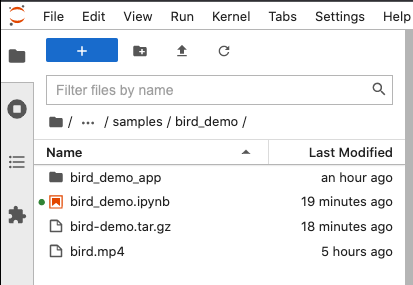

Run the `bird_demo.ipynb` notebook to test your application code and model.

![Panorama Test Utility](statics/panorama_test.png)

## Clean Up

---
Please do not forget to clean up after you are down with this lab.

1) You can manually remove the label jobs in the SageMaker Console.

2) To clean up your pipelines and model groups using the clean up code below.

3) Goto Cloudformation and delete stack to remove your Panorama Test Utility setup.

In [ ]:
def delete_model_package_group(sm_client, package_group_name):
    try:
        model_versions = sm_client.list_model_packages(ModelPackageGroupName=package_group_name)

    except Exception as e:
        print("{} \n".format(e))
        return

    for model_version in model_versions["ModelPackageSummaryList"]:
        try:
            sm_client.delete_model_package(ModelPackageName=model_version["ModelPackageArn"])
        except Exception as e:
            print("{} \n".format(e))
        time.sleep(0.5)  # Ensure requests aren't throttled

    try:
        sm_client.delete_model_package_group(ModelPackageGroupName=package_group_name)
        print("{} model package group deleted".format(package_group_name))
    except Exception as e:
        print("{} \n".format(e))
    return


def delete_sagemaker_pipeline(sm_client, pipeline_name):
    try:
        sm_client.delete_pipeline(
            PipelineName=pipeline_name,
        )
        print("{} pipeline deleted".format(pipeline_name))
    except Exception as e:
        print("{} \n".format(e))
        return
    
def delete_sagemaker_project(sm_client, project_name):
    try:
        sm_client.delete_project(
            ProjectName=project_name,
        )
        print("{} project deleted".format(project_name))
    except Exception as e:
        print("{} \n".format(e))
        return

In [ ]:
import boto3
import time

client = boto3.client("sagemaker")

delete_model_package_group(client, model_package_group_name)
delete_sagemaker_pipeline(client, pipeline_name)